In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_clust_cos_tcn import Sub_Clust_Cos_TCN

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "V_diff.npy"
V_file = "V_resid_s2_h8.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

In [3]:
T_train = 995 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 8
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

batch_length = 50000
batch_size = 5
iter_no = 9950*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Sub_Clust_Cos_TCN(sub_no, E_no, I_no, T_no, H_no, device)
syn_params = []
rest_params = []

for name, params in model.named_parameters():
    if (name == "C_syn_e_raw") or (name == "C_syn_i_raw"):
        syn_params.append(params)
    else:
        rest_params.append(params)

optimizer = torch.optim.Adam(rest_params, lr = 0.005)
syn_optimizer = torch.optim.Adam(syn_params, lr = 0.002)

syn_scheduler = torch.optim.lr_scheduler.StepLR(syn_optimizer, step_size=50, gamma=0.97)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

20601


In [6]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


score_list = []
temp_list = np.logspace(0.5,-3,100)
temp_count = 0

beta = 1
kl_ref_e = torch.ones(sub_no, E_no).to(device) * 1/sub_no
kl_ref_i = torch.ones(sub_no, I_no).to(device) * 1/sub_no
kl_criterion = nn.KLDivLoss()

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (temp_count < 99) & (i%100 == 99):
        temp_count += 1
    if i%50 == 49:
        beta *= 0.9
    temp = temp_list[temp_count]
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _, _, log_C_syn_e, log_C_syn_i  = model(batch_E_neural[:,:,:], batch_I_neural[:,:,:], temp)
    kl_loss = kl_criterion(log_C_syn_e, kl_ref_e) + kl_criterion(log_C_syn_i, kl_ref_i)
    
    loss = torch.mean((V_pred - batch_V[:,:])**2) + beta * kl_loss
    loss.backward()
    optimizer.step()
    syn_optimizer.step()
    syn_scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_C_syn_e, test_C_syn_i, _, _ = model(test_E_neural.unsqueeze(0)[:,:,:], test_I_neural.unsqueeze(0)[:,:,:], 0.0001)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[:].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list.append(test_score)
                        
        print(i, np.round(test_score,6),
              np.round(test_mse,6),
             np.round(kl_loss.item(),6))


0 -0.12857 0.980963 0.0
49 -0.170343 0.13088 2.3e-05
99 -0.539929 0.177326 0.00015
149 -0.632559 0.204588 0.000317
199 -0.426025 0.175734 0.000517
249 -0.239368 0.16151 0.00062
299 -0.235774 0.162345 0.000842
349 -0.105739 0.136268 0.000899
399 -0.162277 0.130724 0.001102
449 -0.167767 0.130037 0.001162
499 -0.087708 0.126191 0.001459
549 -0.079051 0.127373 0.001576
599 -0.094361 0.126444 0.002002
649 -0.082587 0.138436 0.002189
699 -0.129344 0.141408 0.002936
749 -0.134511 0.133766 0.003375
799 -0.154087 0.141751 0.004485
849 -0.201616 0.143197 0.005048
899 -0.232405 0.147814 0.006639
949 -0.210543 0.144842 0.007296
999 -0.218648 0.148772 0.009179
1049 -0.220455 0.156693 0.009584
1099 -0.222424 0.160299 0.011559
1149 -0.209237 0.168731 0.011728
1199 -0.168484 0.151546 0.013735
1249 -0.149388 0.177109 0.013643
1299 -0.185706 0.172709 0.015908
1349 -0.127377 0.180454 0.015785
1399 -0.146795 0.152752 0.018305
1449 -0.153382 0.194301 0.01816
1499 -0.178409 0.198499 0.021237
1549 -0.198027

KeyboardInterrupt: 

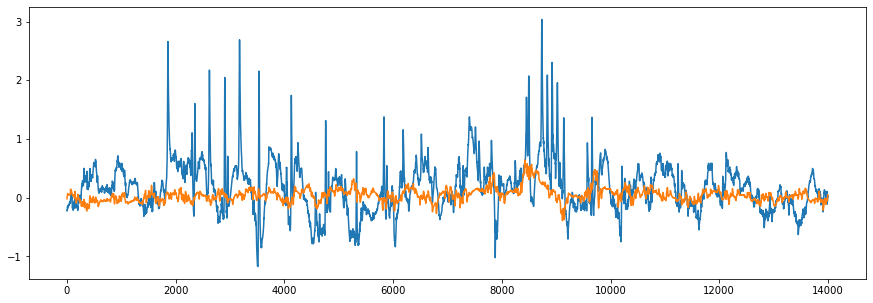

In [7]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:30000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:30000])

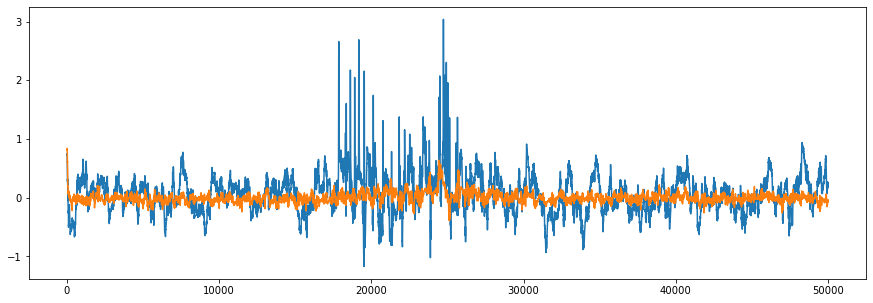

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[:])
plt.plot(test_V_pred.cpu().detach().numpy())

In [12]:
kern_basis = torch.zeros(24, T_no).to(device)
for i in range(24):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = 6  * torch.log(x_in + 1 + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis
    
kern_e = torch.matmul(model.W_e_layer1, kern_basis)
kern_i = torch.matmul(model.W_i_layer1, kern_basis)

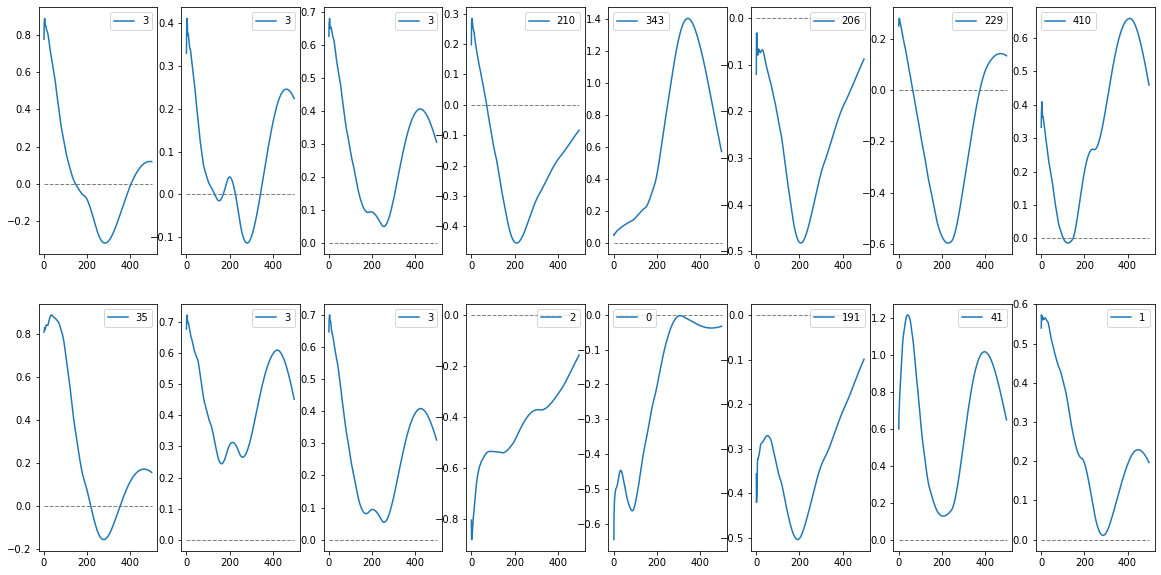

In [13]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,10))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx].cpu().detach().numpy()))
        axs[i,j].plot(kern_e[idx].cpu().detach().numpy(), label=str(max_t))
        axs[i,j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[i,j].legend()

In [14]:
C_syn_plot = np.zeros((E_no))

for e in range(E_no):
    C_syn_plot[e] = torch.argmax(model.C_syn_e_raw[:,e])

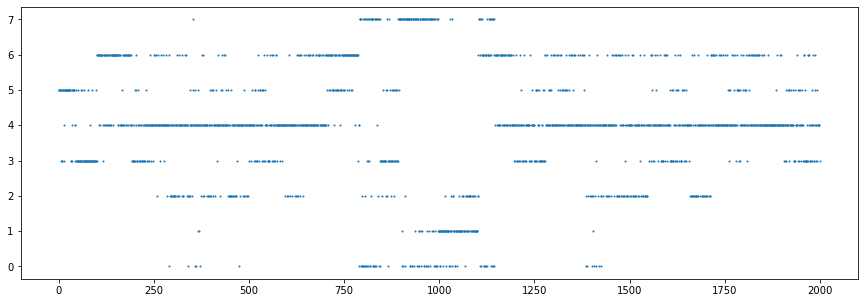

In [15]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), C_syn_plot, s=1)

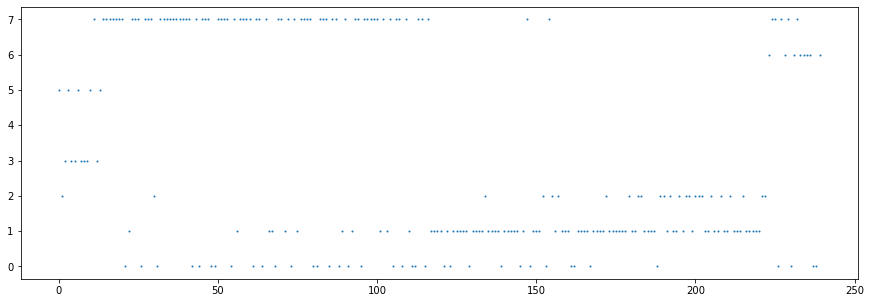

In [16]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(240), C_syn_plot[880:1120], s=1)

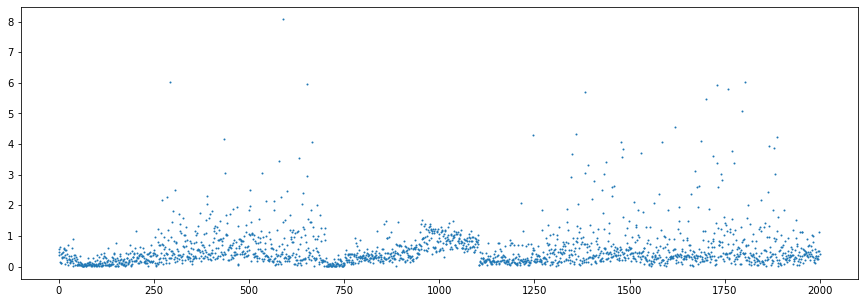

In [17]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), np.exp(model.E_scale.cpu().detach().numpy()), s=1)

In [16]:
torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/glm_whole_s2_h8.pt")

# RESIDUAL

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V -= np.mean(V)

H_no = 2
sub_no = 8
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

model = Sub_Clust_Cos_TCN(sub_no, E_no, I_no, T_no, H_no, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/glm_whole_s2_h8.pt"))
model.eval()
model.cuda()

Sub_Clust_Cos_TCN()

In [4]:
V_resid = np.empty((1000,50000))

for i in tnrange(1000):
    batch_E_neural = E_neural[i*50000:i*50000+50000].toarray().reshape(1, 50000, -1)
    batch_I_neural = I_neural[i*50000:i*50000+50000].toarray().reshape(1, 50000, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    V_pred, _, _, log_C_syn_e, log_C_syn_i  = model(batch_E_neural, batch_I_neural, 0.0001)
    V_resid[i] = V[i*50000:i*50000+50000] - V_pred.cpu().detach().numpy().flatten()

<ipython-input-4-023f4736aeba>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(1000):


In [5]:
print(V_pred.shape)

torch.Size([1, 50000])


In [11]:
np.save("/media/hdd01/sklee/CA1_clust4-60/V_resid_s2_h8.npy", V_resid.flatten())

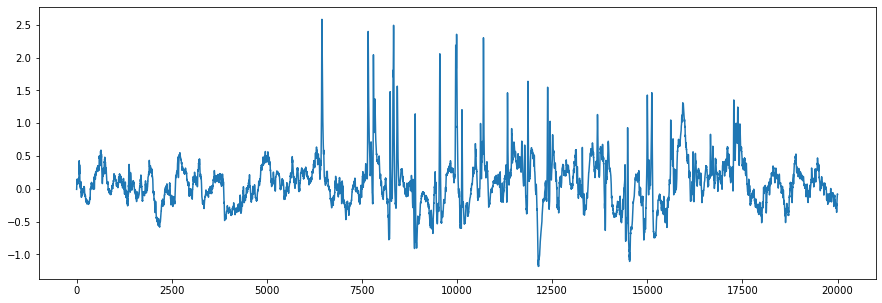

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_resid[0][10000:30000])